In [1]:
import dask
import dask.dataframe as dd
import xarray as xr
import pandas as pd
import numpy as np
import warnings

from matplotlib import pyplot as plt
from dask.distributed import progress
from dask.distributed import Client, LocalCluster

warnings.filterwarnings('ignore')

In [2]:
print("Starting local cluster...")
cluster = LocalCluster(n_workers=1, threads_per_worker=1) 
client = Client(cluster)
client

Starting local cluster...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46006,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:34435,Total threads: 1
Dashboard: http://127.0.0.1:41284/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:35750,


In [3]:
ds = xr.open_zarr('/storage/arbennett/cmip_swe/training.zarr',)
print('This dataset is ~', int(ds.nbytes / 1e9), 'GB')
ds

This dataset is ~ 182 GB


<xarray.Dataset>
Dimensions:         (lat: 721, lon: 1440, time: 10957)
Coordinates:
  * lat             (lat) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon             (lon) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time            (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31
Data variables:
    aspect_cosine   (lat, lon) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    cbrt_elevation  (lat, lon) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    cbrt_pr         (time, lat, lon) float32 dask.array<chunksize=(720, 150, 150), meta=np.ndarray>
    cbrt_swe        (time, lat, lon) float32 dask.array<chunksize=(720, 150, 150), meta=np.ndarray>
    mask            (lat, lon) int64 dask.array<chunksize=(181, 360), meta=np.ndarray>
    tasmax          (time, lat, lon) float32 dask.array<chunksize=(720, 150, 150), meta=np.ndarray>
    tasmin          (time, lat, lon) float32 dask.array<chunksize=(720, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

In [4]:
seasonal_temp = ds['tasmax'].groupby('time.season').mean('time').compute()

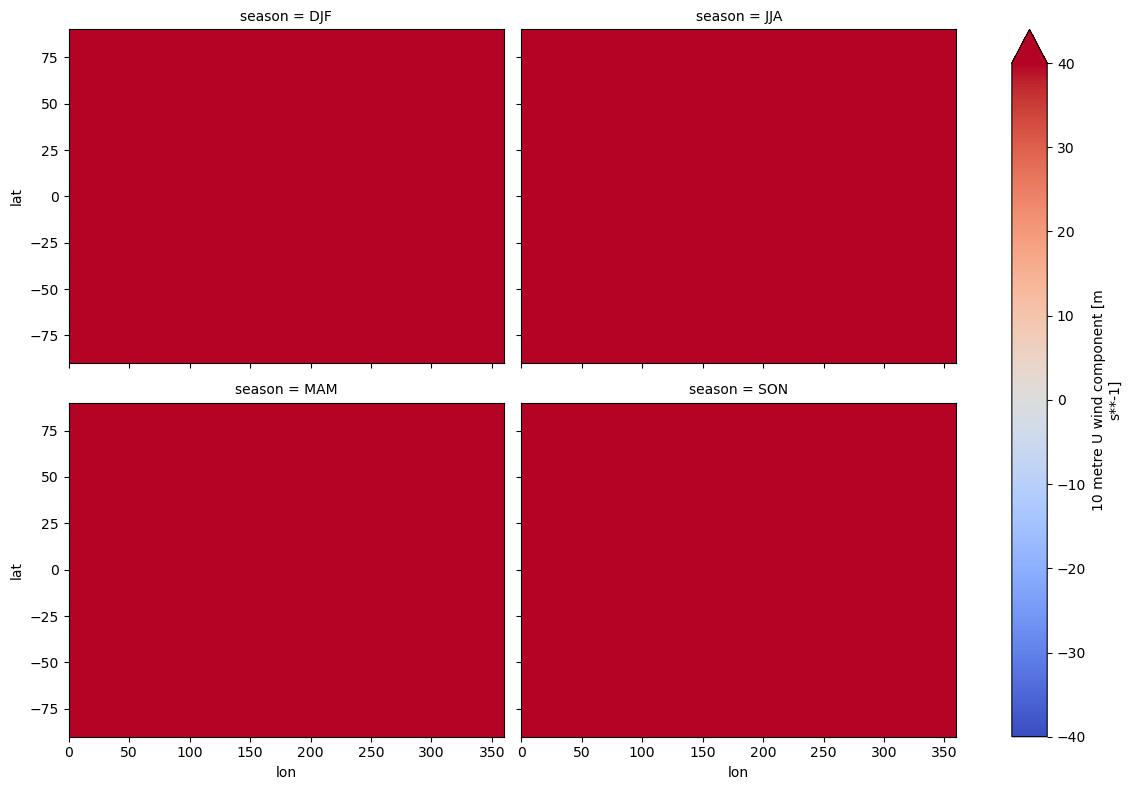

In [5]:
seasonal_temp.plot(
    x='lon', y='lat', col='season', 
    col_wrap=2, cmap='coolwarm', figsize=(12, 8), 
    vmin=-40, vmax=40
)

# Oh no, the data was in Kelvin! We need to recompute and wait for the result again.

In [8]:
seasonal_temp.mean()

<xarray.DataArray 'tasmax' ()>
array(280.37213, dtype=float32)

In [9]:
client.cluster.scale(16)

In [11]:
seasonal_temp = (ds['tasmax'].groupby('time.season').mean('time') - 273.15).compute()

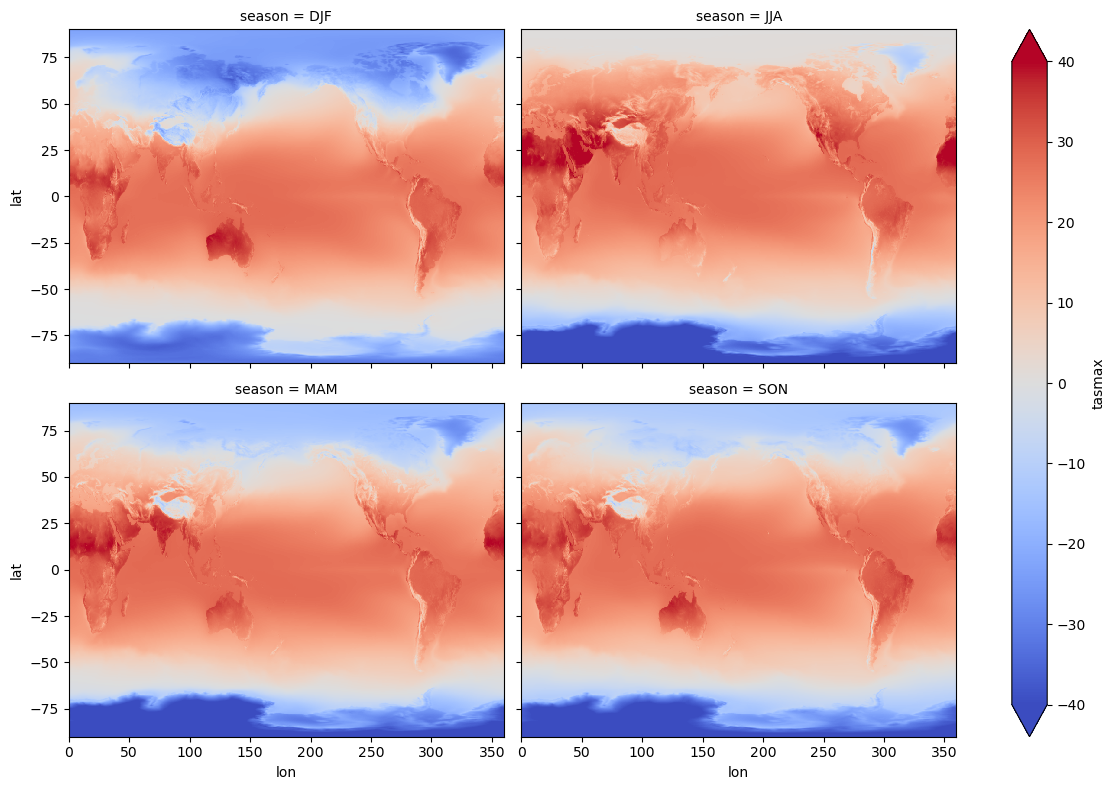

In [12]:
seasonal_temp.plot(
    x='lon', y='lat', col='season', 
    col_wrap=2, cmap='coolwarm', figsize=(12, 8), 
    vmin=-40, vmax=40
)

# How far can we go!?

In [13]:
client.cluster.scale(128)

In [14]:
seasonal_temp = (ds['tasmax'].groupby('time.season').mean('time') - 273.15).compute()

# The key is in the data chunking!

In [21]:
# Scale back down because we don't need it
client.cluster.scale(16)
ds

<xarray.Dataset>
Dimensions:         (lat: 721, lon: 1440, time: 10957)
Coordinates:
  * lat             (lat) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon             (lon) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time            (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31
Data variables:
    aspect_cosine   (lat, lon) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    cbrt_elevation  (lat, lon) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    cbrt_pr         (time, lat, lon) float32 dask.array<chunksize=(720, 150, 150), meta=np.ndarray>
    cbrt_swe        (time, lat, lon) float32 dask.array<chunksize=(720, 150, 150), meta=np.ndarray>
    mask            (lat, lon) int64 dask.array<chunksize=(181, 360), meta=np.ndarray>
    tasmax          (time, lat, lon) float32 dask.array<chunksize=(720, 150, 150), meta=np.ndarray>
    tasmin          (time, lat, lon) float32 dask.array<chunksize=(720, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

In [25]:
365/5

73.0

In [26]:
ds = xr.open_zarr(
    '/storage/arbennett/cmip_swe/training.zarr',
    chunks={'time': 365, 'lat': -1, 'lon': -1}
)
ds

<xarray.Dataset>
Dimensions:         (lat: 721, lon: 1440, time: 10957)
Coordinates:
  * lat             (lat) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon             (lon) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time            (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31
Data variables:
    aspect_cosine   (lat, lon) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    cbrt_elevation  (lat, lon) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    cbrt_pr         (time, lat, lon) float32 dask.array<chunksize=(73, 721, 1440), meta=np.ndarray>
    cbrt_swe        (time, lat, lon) float32 dask.array<chunksize=(73, 721, 1440), meta=np.ndarray>
    mask            (lat, lon) int64 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    tasmax          (time, lat, lon) float32 dask.array<chunksize=(73, 721, 1440), meta=np.ndarray>
    tasmin          (time, lat, lon) float32 dask.array<chunksize=(73, 721, 1440), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

In [27]:
seasonal_temp = (ds['tasmax'].groupby('time.season').mean('time') - 273.15).compute()